# Classification and Regression

In [1]:
import math
import time
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import edward2 as ed
from dbnn.dbnn import DBNN
from dbnn.och import OCH

In [2]:
savefig = False

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

if not savefig:
    plt.rcParams["figure.figsize"] = (4, 4)
    plt.rcParams["font.size"] = 15
    plt.rcParams["figure.titlesize"] = 25
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"] = 15
    plt.rcParams["legend.fontsize"] = 13
    plt.rcParams["lines.linewidth"] = 2
else:
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.rcParams["font.size"] = 30
    plt.rcParams["axes.labelsize"] = 53
    plt.rcParams["xtick.labelsize"] = 40
    plt.rcParams["ytick.labelsize"] = 40
    plt.rcParams["legend.fontsize"] = 28
    plt.rcParams["lines.linewidth"] = 4

In [3]:
# paths
dataset_root = 'datasets/'

# experiments
seed = 30
tf.random.set_seed(seed)
np.random.seed(seed)

# och parameters
och_x1_params = {'k': 5, 'l': 5.0, 's': 1.0}
och_x_params = {'k': 5, 'l': 1.0, 's': 1.0}
och_y_params = {'k': 5, 'l': 1.0, 's': 1.0}

# style
alpha = 0.12
colors = ["tab:blue", "tab:green", "tab:purple", "tab:red"]
labels = ["DNN", "MU", "DU", "DBNN"]
guide_linestyle=(0, (1, 1))
linestyles = [(0, (5, 1)), 'solid', (0, (5, 1)), 'solid']

In [4]:
def dnn_op(model, x):
    preds = model(tf.stack([x]))
    return preds

def bnn_op(model, x):
    preds = tf.unstack(model(tf.stack([x])), axis=-1)
    return tfd.Normal(loc=preds[0], scale=tf.math.softplus(preds[1])).sample()

## Toy Example of Regression

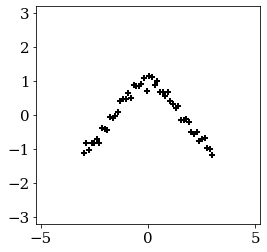

In [5]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlim(-5.2, 5.2)
ax.set_ylim(-3.2, 3.2)
ax.scatter(x_train, y_train, color="black", s=30, marker="+", label="Training")

### Train

Train DNN:

In [6]:
dnn = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

In [7]:
epochs, batch = 150, 10

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
train_loss = tf.keras.metrics.Mean(name='train_loss')
loss_obj = tf.keras.losses.MSE

def train_step(xs, ys):
    with tf.GradientTape() as tape:
        preds = dnn(xs)
        loss = loss_obj(ys, preds)
    gradients = tape.gradient(loss, dnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dnn.trainable_variables))
    
    train_loss(loss)

for epoch in range(epochs):
    indexes_batch = np.array_split(np.random.permutation(len(x_train)), len(x_train) / batch + 1)
    indexes_batch = [indexes for indexes in indexes_batch if len(indexes) > 0]
    
    for indexes in indexes_batch:
        xs = tf.stack([x_train[index] for index in indexes])
        ys = tf.stack([y_train[index] for index in indexes])
        train_step(xs, ys)
        
    if (epoch + 1) % 30 == 0:
        template = 'Epoch {}, Loss: {}'
        print(template.format(epoch + 1,
                              train_loss.result()))
        train_loss.reset_states()

Epoch 30, Loss: 0.04748153313994408
Epoch 60, Loss: 0.015438433736562729
Epoch 90, Loss: 0.01476532407104969
Epoch 120, Loss: 0.01418133545666933
Epoch 150, Loss: 0.013801822438836098


Train BNN:

In [8]:
bnn = tf.keras.Sequential([
    tfp.layers.DenseFlipout(10, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(10, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(2)
])

In [9]:
epochs, batch = 300, 10

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
train_loss = tf.keras.metrics.Mean(name='train_loss')
nll_loss = tf.keras.metrics.Mean(name='nll_loss')

def train_step(xs, ys):
    with tf.GradientTape() as tape:
        preds = [tf.expand_dims(pred, axis=-1) for pred in tf.unstack(bnn(xs), axis=-1)]
        nll = - tf.reduce_mean(tfd.Normal(loc=preds[0], scale=tf.math.softplus(preds[1])).log_prob(ys))
        kl = sum(bnn.losses) / len(x_train)
        loss = nll + kl
    gradients = tape.gradient(loss, bnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bnn.trainable_variables))
    
    train_loss(loss)
    nll_loss(nll)

for epoch in range(epochs):
    indexes_batch = np.array_split(np.random.permutation(len(x_train)), len(x_train) / batch + 1)
    indexes_batch = [indexes for indexes in indexes_batch if len(indexes) > 0]
    
    for indexes in indexes_batch:
        xs = tf.stack([x_train[index] for index in indexes])
        ys = tf.stack([y_train[index] for index in indexes])
        train_step(xs, ys)
        
    if (epoch + 1) % 30 == 0:
        template = 'Epoch {}, Loss: {}, NLL: {}'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              nll_loss.result()))
        train_loss.reset_states()
        nll_loss.reset_states()

Instructions for updating:
Please use `layer.add_weight` method instead.
Epoch 30, Loss: 5.1638994216918945, NLL: 0.480219304561615
Epoch 60, Loss: 2.417167901992798, NLL: 0.09184245020151138
Epoch 90, Loss: 1.4353293180465698, NLL: -0.05196693167090416
Epoch 120, Loss: 1.1644970178604126, NLL: -0.08812980353832245
Epoch 150, Loss: 1.0319085121154785, NLL: -0.105350561439991
Epoch 180, Loss: 0.9564077854156494, NLL: -0.09755897521972656
Epoch 210, Loss: 0.7550378441810608, NLL: -0.26437726616859436
Epoch 240, Loss: 0.595346212387085, NLL: -0.40237295627593994
Epoch 270, Loss: 0.567963719367981, NLL: -0.41297027468681335
Epoch 300, Loss: 0.820416271686554, NLL: -0.14531636238098145


### Test

In [10]:
x_pred = np.linspace(-5, 5, num=50)
x_pred = x_pred.astype(np.float32).reshape((50, 1))

DNN:

In [11]:
dnn_x_pred, dnn_y_pred, dnn_runtimes = [], [], []
for x in x_pred:
    time1 = time.time()
    dnn_x_pred.append(x)
    dnn_y_pred.append(dnn(tf.stack([x]))[0].numpy())
    time2 = time.time()
    dnn_runtimes.append(time2 - time1)
    
print("DNN Runtime: %.3f ± %.3f (ms)" % (np.mean(dnn_runtimes) * 10 ** 3, np.std(dnn_runtimes) * 10 ** 3))

DNN Runtime: 1.673 ± 4.795 (ms)


MU:

In [12]:
sample_no = 5

mu_x_pred, mu_y_pred, mu_runtimes = [], [], []
for x in x_pred:
    time1 = time.time()
    for _ in range(sample_no):
        mu_pred = tf.unstack(bnn(tf.stack([x])), axis=-1)
        mu_x_pred.append(x)
        mu_y_pred.append(tfd.Normal(loc=mu_pred[0], scale=tf.math.softplus(mu_pred[1])).sample()[0].numpy())
    time2 = time.time()
    mu_runtimes.append(time2 - time1)
    
print("MU Runtime: %.3f ± %.3f (ms)" % (np.mean(mu_runtimes) * 10 ** 3, np.std(mu_runtimes) * 10 ** 3))

MU Runtime: 141.661 ± 23.695 (ms)


DU:

In [13]:
sample_no = 5

x_dims, y_dims, x_1s = [1, 1], [1], [[0]]
och_x_1 = OCH(**och_x1_params, dims=x_dims[1:], hash_no=3, cs=x_1s)
och_x = OCH(**och_x_params, dims=x_dims, hash_no=1)
och_y = OCH(**och_y_params, dims=y_dims, hash_no=1)
du = DBNN(lambda x: dnn_op(dnn, x[0]), och_x_1, och_x, och_y)

du_x_pred, du_y_pred, du_runtimes = [], [], []
for x in x_pred:
    time1 = time.time()
    du.update(x)
    time2 = time.time()
    du_runtimes.append(time2 - time1)
    for _ in range(sample_no):
        _x_pred, _y_pred = du.och_x.sample(), du.och_y.sample()
        if _x_pred is not None and _y_pred is not None:
            du_x_pred.append(_x_pred[0])
            du_y_pred.append(_y_pred.numpy())

print("DU Runtime: %.3f ± %.3f (ms)" % (np.mean(du_runtimes) * 10 ** 3, np.std(du_runtimes) * 10 ** 3))

DU Runtime: 11.536 ± 7.904 (ms)


DBNN:

In [14]:
sample_no = 5

x_dims, y_dims, x_1s = [1, 1], [1], [list(range(och_x1_params["k"]))]
och_x_1 = OCH(**och_x1_params, dims=x_dims[1:], hash_no=3, cs=x_1s)
och_x = OCH(**och_x_params, dims=x_dims, hash_no=1)
och_y = OCH(**och_y_params, dims=y_dims, hash_no=1)
dbnn = DBNN(lambda x: bnn_op(bnn, x[0]), och_x_1, och_x, och_y)

dbnn_x_pred, dbnn_y_pred, dbnn_runtimes = [], [], []
for x in x_pred:
    time1 = time.time()
    dbnn.update(x)
    time2 = time.time()
    dbnn_runtimes.append(time2 - time1)
    for _ in range(sample_no):
        _x_pred, _y_pred = dbnn.och_x.sample(), dbnn.och_y.sample()
        if _x_pred is not None and _y_pred is not None:
            dbnn_x_pred.append(_x_pred[0])
            dbnn_y_pred.append(_y_pred.numpy())

print("DBNN Runtime: %.3f ± %.3f (ms)" % (np.mean(dbnn_runtimes) * 10 ** 3, np.std(dbnn_runtimes) * 10 ** 3))

DBNN Runtime: 29.409 ± 13.689 (ms)


Visualize results:

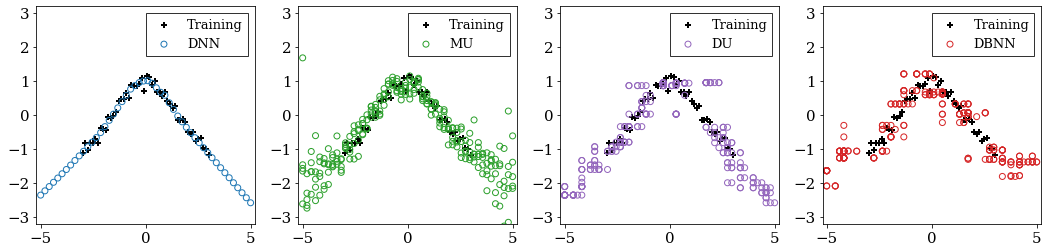

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
datasets = [(dnn_x_pred, dnn_y_pred), (mu_x_pred, mu_y_pred), (du_x_pred, du_y_pred), (dbnn_x_pred, dbnn_y_pred)]
for ax, preds, label, color in zip(axes, datasets, ["DNN", "MU", "DU", "DBNN"], colors):
    ax.set_xlim(-5.2, 5.2)
    ax.set_ylim(-3.2, 3.2)
    ax.scatter(x_train, y_train, color="black", s=30, marker="+", label="Training")
    ax.scatter(preds[0], preds[1], facecolors="none", edgecolors=color, label=label)
    ax.legend(edgecolor='black', fancybox=False)